In [1]:
import pickle
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln, digamma
from scipy.stats import spearmanr, pearsonr, ttest_ind, ttest_rel

#Identify current working directory
cwd = os.getcwd()

#Create Analysis Folder
if not os.path.exists(cwd + '/Analysis/Modeling'):
    os.mkdir(cwd + '/Analysis/Modeling')

# Import and organise data
- Early-onset LFP/ERP: Magnitude of (negative) peak in first 50 ms post-stimulus
- Late-onset LFP/ERP: Mean value from 100 to 250 ms post-stimulus
- $\alpha$ PSD: 8-12 Hz (indices 2,3)
- $\beta$ PSD: 16-28 Hz (indices 4,…,7)
- $\gamma$ PSD: 32-60 Hz (indices 8,…,16)

In [5]:
#Select Data to Load -  EITHER S1-C1 Principal Column OR S2 Data 

#S1 
ds = pickle.load(open(cwd +  "/Data/S1_SummaryData_Modeling.pickle", "rb"))
#ds = pickle.load(open(cwd +  "/Data/SummaryData_ERP-PSD-RMS_S1.pickle", "rb"))
ctx = "S1"
removeShank = 0

# #S2 
# ds = pickle.load(open(cwd + "/Data/S2_SummaryData_Modeling.pickle", "rb"))
# ctx = "S2"
# removeShank = 1

In [6]:
del ds["PSD_freqs"]
del ds["prestimPSD_freqs"]
del ds["trode"]
del ds["ketID"]
del ds["whiskerID"]

ds["erp_eo"] = []
for trial in ds["ERP"]:
    ds["erp_eo"].append(-np.min(trial[1:, 50:100], axis=1))

ds["erp_lo"] = []
for trial in ds["ERP"]:
    ds["erp_lo"].append(np.mean(trial[1:, 150:], axis=1))

ds["psd_a"] = []
for trial in ds["PSD"]:
    ds["psd_a"].append(np.mean(trial[1:, 2:4], axis=1))

ds["psd_b"] = []
for trial in ds["PSD"]:
    ds["psd_b"].append(np.mean(trial[1:, 4:8], axis=1))

ds["psd_g"] = []
for trial in ds["PSD"]:
    ds["psd_g"].append(np.mean(trial[1:, 8:16], axis=1))
    
ds["psd_by_freq"] = []
for trial in ds["PSD"]:
    ds["psd_by_freq"].append(trial[1:, 2:16])

psd_by_freq = np.array(np.copy(ds["PSD"]))
psd_by_freq = [arr.tolist() for arr in psd_by_freq]
psd_by_freq = np.array(psd_by_freq)
psd_by_freq = psd_by_freq[:, 1:, 2:16]

del ds["ERP"]
del ds["PSD"]
del ds["prestimPSD"]

# Define CD model and BS helper functions
- We use a sigmoid forgetting kernel thresholded to 0.1.
- Decay parameter $\tau \in [1, 20]$ plotted here. We end up using $\tau=10$.
- We also define a surprisal series (in the frequentist sense), which is simply the logarithm of the probability of encountering a given stimulus

In [7]:
#Initialize Sequences 
#Patterned sequence

isi = .25 #inter-stimulus interval in seconds 

#0 - C1
#1 - C2
#2 - D1
#3 - B1 

patternBase = np.array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, \
       2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 0, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, \
       3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 0, 1, 2, 3, 1, 2, 3, \
       1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, \
       0, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1])
patternSeq = np.tile(patternBase, 40)

#Random sequence 
randomBase = np.array([1, 3, 2, 3, 2, 1, 2, 1, 3, 3, 1, 2, 2, 1, 3, 1, 2, 3, 2, 3, 1, 1, \
       3, 2, 2, 1, 3, 3, 2, 1, 1, 3, 2, 0, 2, 1, 2, 1, 3, 3, 1, 2, 2, 1, \
       3, 1, 2, 3, 2, 3, 3, 1, 3, 2, 2, 1, 2, 3, 1, 0, 1, 3, 2, 3, 2, 1, \
       2, 1, 3, 3, 1, 2, 2, 1, 3, 1, 2, 3, 2, 3, 1, 1, 3, 1, 2, 1, 2, 3, \
       0, 1, 1, 3, 2, 3, 2, 1, 2, 1, 3, 3])
randomSeq = np.tile(randomBase, 40)

#Make Whisker Identity update matrix from sequences (Row entry: update made at each timestep, Column entry: state observed)
def stateSpace(array):
  outputMat = [] 
  for obs in array:
    if obs == 1:
      outputMat.append([1,0,0,0])
    if obs == 2:
      outputMat.append([0,1,0,0])
    if obs == 3:
      outputMat.append([0,0,1,0])
    if obs == 0:
      outputMat.append([0,0,0,1])
  outputMat = np.asarray(outputMat)
  return outputMat    

#Make Transition update matrix from sequences (Row entry: update made at each timestep, Column entry: state observed)
#0: 1 --> 1
#1: 1 --> 2
#2: 1 --> 3
#3: 2 --> 1
#4: 2 --> 2
#5: 2 --> 3
#6: 3 --> 1
#7: 3 --> 2
#8: 3 --> 3
#9: 0 --> 1
#10: 0 --> 2
#11: 0 --> 3
#12: 1 --> 0
#13: 2 --> 0
#14: 3 --> 0
#15: 0 --> 0 
def transitionSpace(array):   
  outputMat = [] 
  for obs in np.arange(np.shape(array)[0] -1):
    transition = [array[obs], array[obs + 1]]
    if transition == [1, 1]:
      outputMat.append([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    if transition == [1, 2]:
      outputMat.append([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    if transition == [1, 3]:
      outputMat.append([0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0])
    if transition == [2, 1]:
      outputMat.append([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
    if transition == [2, 2]:
      outputMat.append([0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0])
    if transition == [2, 3]:
      outputMat.append([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0])
    if transition == [3, 1]:
      outputMat.append([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]) 
    if transition == [3, 2]:
      outputMat.append([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])    
    if transition == [3, 3]:
      outputMat.append([0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0])
    if transition == [0, 1]:
      outputMat.append([0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0])  
    if transition == [0, 2]:
      outputMat.append([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]) 
    if transition == [0, 3]:
      outputMat.append([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])    
    if transition == [1, 0]:
      outputMat.append([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0])    
    if transition == [2, 0]:
      outputMat.append([0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0])  
    if transition == [3, 0]:
      outputMat.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0])     
    if transition == [0, 0]:
      outputMat.append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])
  outputMat = np.asarray(outputMat)
  return outputMat     

patternStates_100 = stateSpace(patternBase)
patternStates = stateSpace(patternSeq)

randomStates_100 = stateSpace(randomBase)
randomStates = stateSpace(randomSeq)

patternTransitions_100 = transitionSpace(patternBase)
patternTransitions = transitionSpace(patternSeq)

randomTransitions_100 = transitionSpace(randomBase)
randomTransitions = transitionSpace(randomSeq)    

#Bayesian Surprise Functions

#Calculate the Kulback-Leibler Divergence between dirichlet prior and posterior 
#Input is row array of Dirichlet prior parameters (alphas) and Dirichlet posterior parameters (betas) 
def KL_div(alphas, betas):

  alpha_sum = sum(alphas)
  beta_sum = sum(betas)

  indv = gammaln(alpha_sum) - sum(gammaln(alphas)) - gammaln(beta_sum) +sum(gammaln(betas))
  comb = sum((alphas - betas) * (digamma(alphas) - digamma(alpha_sum)))

  dKL = indv + comb

  return dKL

#Update and calculate KL divergence by trial 
def KL_trialbyTrial(data, init):
  kl_div_byTrial = [] 
  alphas = init
  for row in np.arange(np.shape(data)[0]):
    obs = data[row,:]
    alphas = alphas + obs
    kl_div_byTrial.append(KL_div(alphas, alphas + obs))
  return kl_div_byTrial 

#Plot KL divergence over trials
def KL_plot(klData, titleName):
  plt.figure(figsize=(20, 2))
  plt.plot(klData)
  plt.title(titleName)
  plt.xlabel('Trial')

#Update and calculate KL divergence over time with exponential forgetting
def KL_trialbytrial_decay(data, init, weights):
  kl_div_byTrial = []
  alphas = init 
  data = np.vstack((alphas,data))
  for row in np.arange(np.shape(data)[0]):
    
    #Cut weights array to be as long as observations to date 
    cut_weights = weights[-int(row+1):]

    #Cut data array to be as long as observations to date 
    cut_data = data[0:int(row+1),:]

    #Compute new alphas (called betas for disambiguity)
    betas = np.dot(cut_weights.T, cut_data)  

    #Compute KL divergence
    kl_div_byTrial.append(KL_div(alphas, betas))

    #Set posterior to prior for next step
    alphas = betas  

  return kl_div_byTrial

#Transition lainar label to laminar label 
def laminar_labelTolayer(array):
    
    depth = [] 
    #Iterate through array
    for element in array: 
        if element == 'SG1':
            depth.append('SG')
        if element == 'SG2':
            depth.append('SG')
        if element == 'SG3':
            depth.append('SG')
        if element == 'G1':
            depth.append('G')
        if element == 'G2':
            depth.append('G')
        if element == 'IG1':
            depth.append('IGU')
        if element == 'IG2':
            depth.append('IGU')
        if element == 'IG3':
            depth.append('IGU')
        if element == 'IG4':
            depth.append('IGL')
        if element == 'IG5':
            depth.append('IGL')
        if element == 'IG6':
            depth.append('IGL')

    depth = np.asarray(depth)
    
    return depth

# Define decay kernel and compute weights

/home/gwendolyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


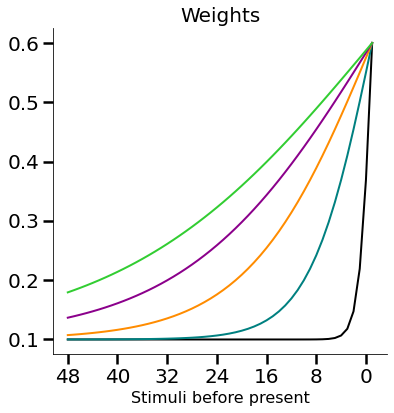

In [8]:
def sigmoid(x, threshold):
    return 1 / (1 + np.exp(-x)) + threshold

threshold = 0.1
tau_values = list(np.arange(1, 21))
stims = np.arange(4001)

weight_arrays = []

for tau in tau_values: weight_arrays.append(sigmoid(stims*np.repeat(-1/tau,4001), threshold))

alphas_init = np.ones(16)

bs_arrays = []
bs_arrays_r = []

for weights in weight_arrays:
    all_weights = np.asarray(weights)[::-1]
    bs = KL_trialbytrial_decay(patternTransitions, alphas_init, all_weights)
    bs = [0.0012*k/max(bs) for k in bs]
    bs = bs[1:]
    bs_arrays.append(bs)

for weights in weight_arrays:
    all_weights = np.asarray(weights)[::-1]
    bs = KL_trialbytrial_decay(randomTransitions, alphas_init, all_weights)
    bs = [0.0012*k/max(bs) for k in bs]
    bs = bs[1:]
    bs_arrays_r.append(bs)

fig, ax = plt.subplots(1, figsize=(6,6))

plt.plot(weight_arrays[0][:50][::-1], label=r"$\tau=1$", linewidth = 2, color = 'black')
plt.plot(weight_arrays[4][:50][::-1], label=r"$\tau=5$", linewidth = 2, color = 'teal')
plt.plot(weight_arrays[9][:50][::-1], label=r"$\tau=10$", linewidth = 2, color = "darkorange" )
plt.plot(weight_arrays[14][:50][::-1], label=r"$\tau=15$", linewidth = 2, color = "darkmagenta" )
plt.plot(weight_arrays[19][:50][::-1], label=r"$\tau=20$", linewidth = 2, color = 'limegreen')

plt.xticks(np.arange(0, 50, 8), np.arange(0, 50, 8)[::-1])

ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("Weights", fontsize = 20)
plt.xlabel(r"Stimuli before present", fontsize = 16)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.savefig(cwd + "/Analysis/Modeling/Weights.png", dpi=2500)

# Bayesian surprise dynamics
- Higher average surprise for probes in patterned paradigm
- Theoretical surprise increases following probe with subsequence decline (note: this also holds for the new kernel)

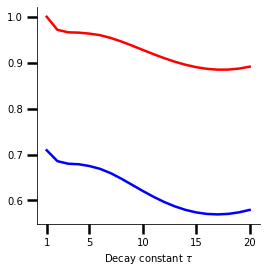

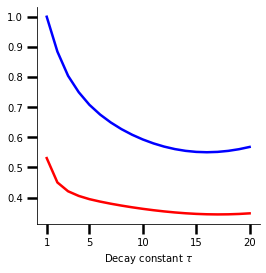

In [9]:
bsmeans_probe = []
bsmeans_r_probe = []

#PROBE STIMULI
for t in range(len(tau_values)):
    bs_mean = []
    bs_mean_r = []

    for i in [33 + 100*j for j in range(40)]:
        bs_mean.append(bs_arrays[t][i])
        bs_mean_r.append(bs_arrays_r[t][i])

    for i in [59 + 100*j for j in range(40)]:
        bs_mean.append(bs_arrays[t][i])
        bs_mean_r.append(bs_arrays_r[t][i])

    for i in [88 + 100*j for j in range(40)]:
        bs_mean.append(bs_arrays[t][i])
        bs_mean_r.append(bs_arrays_r[t][i])

    bsmeans_probe.append(np.mean(bs_mean))
    bsmeans_r_probe.append(np.mean(bs_mean_r))

#Norm max pattern to 1, random correspondingly 
maxBS = max(bsmeans_probe)
probe_bs_sum_p_norm = bsmeans_probe / maxBS
probe_bs_sum_r_norm = bsmeans_r_probe / maxBS

#Plot Probe Surprise Comparison
fig, ax = plt.subplots(1, figsize=(4, 4))
x = np.arange(1,21)
plt.plot(x, probe_bs_sum_p_norm, label="Patterned protocol", c='r', linewidth = 2.5)
plt.plot(x, probe_bs_sum_r_norm, label="Random protocol", c='b', linewidth = 2.5)
plt.xlabel(r"Decay constant $\tau$")
plt.xticks([1,5,10,15,20])

ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(cwd + "/Analysis/Modeling/PatvsRanSurpriseProbe.png", dpi=2500)

#CONTEXT STIMULI
bsmeans_context = []
bsmeans_r_context = []

# Contexts
for t in range(len(tau_values)):
    bs_mean_context = np.mean([x for i, x in enumerate(bs_arrays[t]) if i not in [33 + 100*j for j in range(40)] + [59 + 100*j for j in range(40)] + [88 + 100*j for j in range(40)]])
    bs_mean_r_context = np.mean([x for i, x in enumerate(bs_arrays_r[t]) if i not in [33 + 100*j for j in range(40)] + [59 + 100*j for j in range(40)] + [88 + 100*j for j in range(40)]])
    
    bsmeans_context.append(bs_mean_context)
    bsmeans_r_context.append(bs_mean_r_context)
    
#Norm max random to 1, pattern correspondingly 
maxBS = max(bsmeans_r_context)
context_bs_sum_p_norm = bsmeans_context / maxBS
context_bs_sum_r_norm = bsmeans_r_context / maxBS    
    
#Plot Context Surprise Comparison
fig, ax = plt.subplots(1, figsize=(4, 4))
x = np.arange(1,21)
plt.plot(x, context_bs_sum_p_norm, label="Patterned protocol", c='r', linewidth = 2.5)
plt.plot(x, context_bs_sum_r_norm, label="Random protocol", c='b', linewidth = 2.5)
plt.xlabel(r"Decay constant $\tau$")
plt.xticks([1,5,10,15,20])

ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(cwd + "/Analysis/Modeling/PatvsRanSurpriseContext.png", dpi=2500)    

# Surprise Decline following Probe stimuli

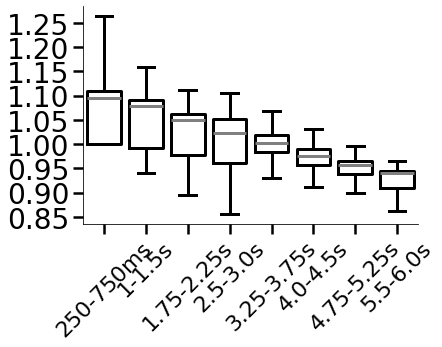

In [10]:
arr_p = np.asarray(bs_arrays[9]) # tau = 10

bsvals = np.zeros((24, 40))
for i in range(40):
    bsvals[:, i] = arr_p[np.arange(34, 58) + 100*i]/arr_p[34+100*i]

bsvals1 = np.zeros((24, 40))
for i in range(40):
    bsvals1[:, i] = arr_p[np.arange(60, 84) + 100*i]/arr_p[60+100*i]

bsvals2 = np.zeros((24, 39))
for i in range(39):
    bsvals2[:, i] = arr_p[np.concatenate((np.arange(89, 99), np.arange(100, 114))) + 100*i]/arr_p[89+100*i]

bsvals_batched = np.hstack((bsvals[::3, :], bsvals[1::3, :], bsvals[2::3, :]))
bsvals_batched1 = np.hstack((bsvals1[::3, :], bsvals1[1::3, :], bsvals1[2::3, :]))
bsvals_batched2 = np.hstack((bsvals2[::3, :], bsvals2[1::3, :], bsvals2[2::3, :]))

fig, ax = plt.subplots(1)#, figsize= (5, 4))

_ = np.hstack([bsvals_batched, bsvals_batched1, bsvals_batched2])
labels = ['250-750ms', '1-1.5s', '1.75-2.25s', '2.5-3.0s', '3.25-3.75s', '4.0-4.5s', '4.75-5.25s', '5.5-6.0s']

bp = plt.boxplot(_.T, labels = labels, positions = [1, 2, 3, 4, 5, 6, 7, 8],  widths=0.8, \
                  showfliers = False,  \
                 whiskerprops = {"linewidth":3,"solid_capstyle": "butt"}, \
                  medianprops={"linewidth": 3, "solid_capstyle": "butt"},\
                  capprops={"linewidth": 3},\
                  boxprops={"linewidth": 3});

for item in ['medians']:    
    plt.setp(bp[item], color='grey', linewidth = 3)


plt.xticks(rotation= 45, fontsize=22)
plt.yticks(fontsize=28) 

ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(cwd + "/Analysis/Modeling/Transient.png", dpi=500)

_ = np.hstack([bsvals_batched, bsvals_batched1])

# Compute correlations (lag-free by definition)
- For every value of $\tau$, we compute the correlation with each of the recorded time series (Spearman's $\rho$)
- We then find the value of $\tau$ that maximizes the correlation in each case

In [11]:
ds["erp_eo_rho"] = []
for idx, trial in enumerate(ds["erp_eo"]):
    if ds["paradigm"][idx] == "P": ds["erp_eo_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays])
    else: ds["erp_eo_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays_r])
        
ds["erp_lo_rho"] = []
for idx, trial in enumerate(ds["erp_lo"]):
    if ds["paradigm"][idx] == "P": ds["erp_lo_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays])
    else: ds["erp_lo_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays_r])

ds["psd_a_rho"] = []
for idx, trial in enumerate(ds["psd_a"]):
    if ds["paradigm"][idx] == "P":  ds["psd_a_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays])
    else: ds["psd_a_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays_r])

ds["psd_b_rho"] = []
for idx, trial in enumerate(ds["psd_b"]):
    if ds["paradigm"][idx] == "P":  ds["psd_b_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays])
    else: ds["psd_b_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays_r])

ds["psd_g_rho"] = []
for idx, trial in enumerate(ds["psd_g"]):
    if ds["paradigm"][idx] == "P":  ds["psd_g_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays])
    else: ds["psd_g_rho"].append([spearmanr(bs_arr, trial[:3999]) for bs_arr in bs_arrays_r])
     

# Plot a few representative parts of the time series

P 1 SG2 mGE89_
R 1 SG2 mGE89_


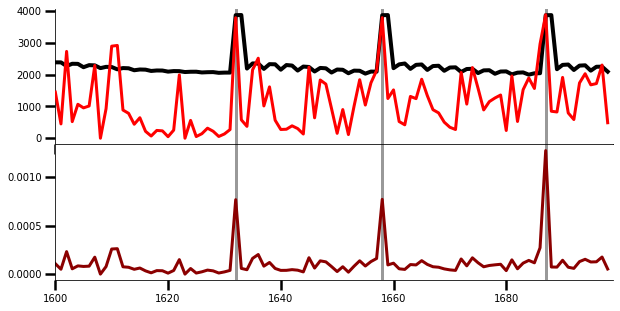

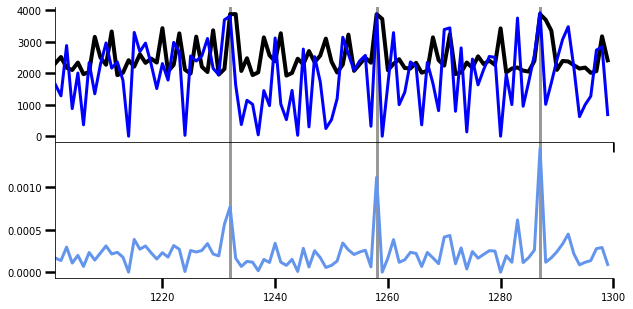

In [12]:
#Select Channel, comment out undesired protocol below 
#Patterned
print(ds["paradigm"][2], ds["shank"][2], ds["layer"][2], ds['animalID'][2]) 

#Select data to plot, comment out undesired 
erp_eo = ds["erp_eo"][2]
erp_eo_ranks = [np.where(np.unique(np.sort(ds["erp_eo"][2]))==el)[0][0] for el in ds["erp_eo"][2]]
tau10_ranks = [np.where(np.unique(np.sort(bs_arrays[9]))==el)[0][0] for el in bs_arrays[9]]

#Initiate Figure
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

#Plot desired lines with specified stimulus range, comment out undesired
#Patterned
start = 1600
stop = 1699
x = np.arange(start, stop)
axs[0].plot(x, erp_eo_ranks[start:stop], linewidth = 3, color = 'red', label=r"Ranked LFP Response", zorder = 10)
axs[0].plot(x, tau10_ranks[start:stop], linewidth = 4, color = 'k', label=r"Bayesian surprise (a.u.), $\tau=10$", zorder = 5)
axs[1].plot(x, erp_eo[start:stop], linewidth = 3, color="darkred", label = "Early-onset ($(0, 50]$ ms) peak LFP response")

#Plot probe stimuli 
for i in range(0,40):
    if (32 + 100*i) > start and (32 + 100*i) < stop: 
        axs[0].axvline(32 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
        axs[1].axvline(32 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
    if (58 + 100*i) > start and (58 + 100*i) < stop:     
        axs[0].axvline(58 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
        axs[1].axvline(58 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
    if (87 + 100*i) > start and (87 + 100*i) < stop: 
        axs[0].axvline(87 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
        axs[1].axvline(87 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)


#Formatting 
plt.xlim([start,stop])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[0].tick_params(axis='both', which='major', width=2.5, length=10)
axs[1].tick_params(axis='both', which='major', width=2.5, length=10)

axs[1].set_yticks(np.arange(0, 0.0015, step=0.0005))

#Save plot
plt.savefig(cwd + "/Analysis/Modeling/Ranked-LFP-Surprise_Pattern.png", dpi = 500)

#Randomized
print(ds["paradigm"][3], ds["shank"][3], ds["layer"][3], ds['animalID'][3]) 

#Select possible data to plot, comment out undesired 
erp_eo_R = ds["erp_eo"][3]
erp_eo_ranks_R = [np.where(np.unique(np.sort(ds["erp_eo"][3]))==el)[0][0] for el in ds["erp_eo"][3]]
tau10_ranks_R = [np.where(np.unique(np.sort(bs_arrays_r[9]))==el)[0][0] for el in bs_arrays_r[9]]

#Initiate figure
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

#Plot desired lines with specified stimulus range
#Randomized
start = 1201
stop = 1300
x = np.arange(start, stop)
axs[0].plot(x, erp_eo_ranks_R[start:stop], linewidth = 3, color = 'blue', label=r"Ranked LFP Response", zorder = 10)
axs[0].plot(x, tau10_ranks_R[start:stop], linewidth = 4, color = 'k', label=r"Bayesian surprise (a.u.), $\tau=10$", zorder = 5)
axs[1].plot(x, erp_eo_R[start:stop], linewidth = 3, color='cornflowerblue', label = "Early-onset ($(0, 50]$ ms) peak LFP response")

#Plot probe stimuli 
for i in range(0,40):
    if (32 + 100*i) > start and (32 + 100*i) < stop: 
        axs[0].axvline(32 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
        axs[1].axvline(32 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
    if (58 + 100*i) > start and (58 + 100*i) < stop:     
        axs[0].axvline(58 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
        axs[1].axvline(58 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
    if (87 + 100*i) > start and (87 + 100*i) < stop: 
        axs[0].axvline(87 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)
        axs[1].axvline(87 + 100*i, color='k', linewidth = 3, alpha=0.4, zorder = 0)

#Formatting 
plt.xlim([start,stop])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[0].tick_params(axis='both', which='major', width=2.5, length=10)
axs[1].tick_params(axis='both', which='major', width=2.5, length=10)

axs[1].set_yticks(np.arange(0, 0.0015, step=0.0005))

#Save plot
plt.savefig(cwd + "/Analysis/Modeling/Ranked-LFP-Surprise_Random.png", dpi = 500)

# Plot Spearman's Rho Heatmap based on all PSD frequency values 

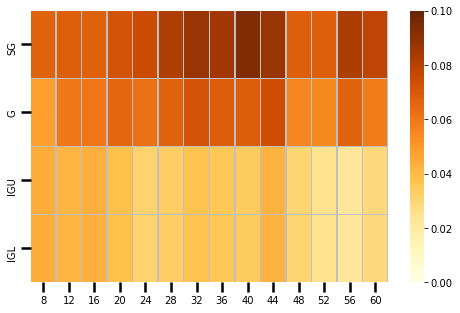

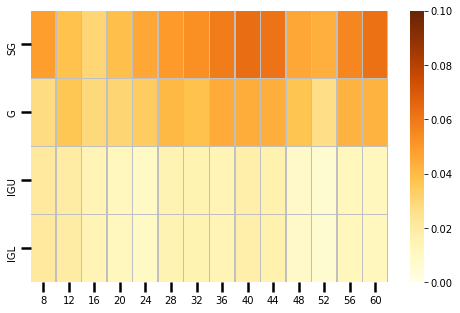

In [13]:
psd_by_freq_rhos = np.empty((psd_by_freq.shape[-1], 0)).tolist()
psd_by_freq_layer = np.empty((psd_by_freq.shape[-1], 0)).tolist()
psd_by_freq_protocol = np.empty((psd_by_freq.shape[-1], 0)).tolist()
psd_by_freq_freq = np.empty((psd_by_freq.shape[-1], 0)).tolist()

for i in range(psd_by_freq.shape[-1]):
    freq = np.arange(8,64,4)[i]
    for idx, trial in enumerate(psd_by_freq[..., i]):
        if ds["paradigm"][idx] == "P" and ds["shank"][idx] != removeShank:  
            psd_by_freq_rhos[i].append([spearmanr(bs_arr, trial[:3999])[0] for bs_arr in bs_arrays])
            psd_by_freq_layer[i].append([ds["layer"][idx] for bs_arr in bs_arrays])
            psd_by_freq_protocol[i].append([ds["paradigm"][idx] for bs_arr in bs_arrays])
            psd_by_freq_freq[i].append([freq for bs_arr in bs_arrays])            
            
        if ds["paradigm"][idx] == "R" and ds["shank"][idx] != removeShank: 
            psd_by_freq_rhos[i].append([spearmanr(bs_arr, trial[:3999])[0] for bs_arr in bs_arrays_r])
            psd_by_freq_layer[i].append([ds["layer"][idx] for bs_arr in bs_arrays])
            psd_by_freq_protocol[i].append([ds["paradigm"][idx] for bs_arr in bs_arrays])
            psd_by_freq_freq[i].append([freq for bs_arr in bs_arrays])
        
psd_by_freq_rhos = np.asarray(psd_by_freq_rhos)      
psd_by_freq_layer = np.asarray(psd_by_freq_layer)
psd_by_freq_protocol = np.asarray(psd_by_freq_protocol)
psd_by_freq_freq = np.asarray(psd_by_freq_freq)
    
#Select data for tau = 10 
psd_by_freq_rhos = psd_by_freq_rhos[:,:,9]
psd_by_freq_layer = psd_by_freq_layer[:,:,9]
psd_by_freq_protocol = psd_by_freq_protocol[:,:,9]
psd_by_freq_freq = psd_by_freq_freq[:,:,9]

#Flatten data 
psd_by_freq_rhos = psd_by_freq_rhos.flatten()
psd_by_freq_layer = psd_by_freq_layer.flatten()
psd_by_freq_protocol = psd_by_freq_protocol.flatten()
psd_by_freq_freq = psd_by_freq_freq.flatten()
psd_by_freq_label = laminar_labelTolayer(psd_by_freq_layer)

#Create dataframe 
df_freq = {'layer':psd_by_freq_layer , 'label': psd_by_freq_label ,'protocol':psd_by_freq_protocol , \
           'rho':psd_by_freq_rhos, 'freq': psd_by_freq_freq} 
df_freq = pd.DataFrame(data = df_freq)

#Calculate means
mean_freq_layer = [[],[],[],[]]
mean_freq_layer_R = [[],[],[],[]]

SG_freq = df_freq[df_freq['layer'].isin(['SG2','SG3'])]
SG_freq_P = SG_freq[SG_freq['protocol']== 'P']
SG_freq_R = SG_freq[SG_freq['protocol']== 'R']

for data_freq in np.arange(8,64,4):
    mean_freq_layer[0].append(SG_freq_P.loc[SG_freq_P['freq'] == data_freq, 'rho'].mean()) 
for data_freq in np.arange(8,64,4):
    mean_freq_layer_R[0].append(SG_freq_R.loc[SG_freq_R['freq'] == data_freq, 'rho'].mean())     

G_freq = df_freq[df_freq['layer'].isin(['G1','G2'])]
G_freq_P = G_freq[G_freq['protocol']== 'P']
G_freq_R = G_freq[G_freq['protocol']== 'R']

for data_freq in np.arange(8,64,4):
    mean_freq_layer[1].append(G_freq_P.loc[G_freq_P['freq'] == data_freq, 'rho'].mean()) 
for data_freq in np.arange(8,64,4):
    mean_freq_layer_R[1].append(G_freq_R.loc[G_freq_R['freq'] == data_freq, 'rho'].mean())  

IGU_freq = df_freq[df_freq['layer'].isin(['IG1','IG2','IG3'])]
IGU_freq_P = IGU_freq[IGU_freq['protocol']== 'P']
IGU_freq_R = IGU_freq[IGU_freq['protocol']== 'R']
 
for data_freq in np.arange(8,64,4):
    mean_freq_layer[2].append(IGU_freq_P.loc[IGU_freq_P['freq'] == data_freq, 'rho'].mean())
for data_freq in np.arange(8,64,4):
    mean_freq_layer_R[2].append(IGU_freq_R.loc[IGU_freq_R['freq'] == data_freq, 'rho'].mean())      
    
IGL_freq = df_freq[df_freq['layer'].isin(['IG4','IG5','IG6'])]
IGL_freq_P = IGU_freq[IGU_freq['protocol']== 'P']
IGL_freq_R = IGU_freq[IGU_freq['protocol']== 'R']
  
for data_freq in np.arange(8,64,4):
    mean_freq_layer[3].append(IGL_freq_P.loc[IGL_freq_P['freq'] == data_freq, 'rho'].mean()) 
for data_freq in np.arange(8,64,4):
    mean_freq_layer_R[3].append(IGL_freq_R.loc[IGL_freq_R['freq'] == data_freq, 'rho'].mean())     
    
x_labels = np.arange(8,64,4)
y_labels = ['SG','G','IGU','IGL']

fig = plt.figure(figsize=(8,5))
ax = plt.axes()
sns.heatmap(mean_freq_layer, vmin = 0, vmax = 0.1, cbar = True, cmap = "YlOrBr", \
                    xticklabels=x_labels, yticklabels=y_labels, linewidths = 0.5, linecolor = 'silver')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.tick_params(axis='both', which='minor', width=2.5, length=5)
plt.savefig(cwd + '/Analysis/Modeling/Patterned_byFreq.png', dpi = 500)

fig = plt.figure(figsize=(8,5))
ax = plt.axes()
sns.heatmap(mean_freq_layer_R, vmin = 0, vmax = 0.1, cbar = True, cmap = "YlOrBr", \
                    xticklabels=x_labels, yticklabels=y_labels, linewidths = 0.5, linecolor = 'silver')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.tick_params(axis='both', which='minor', width=2.5, length=5)
plt.savefig(cwd + '/Analysis/Modeling/Randomized_byFreq.png', dpi = 500)

# Plot correlation by layer

erp_eo_rho patterned paradigm
L2/3 median, tau = 10: 0.23859127294057458
L4 median, tau = 10: 0.20004642023199085
L5 median, tau = 10: 0.13704336837102932
L6 median, tau = 10: 0.06579676931096021
---
erp_eo_rho random paradigm
L2/3 median, tau = 10: 0.16120267664836851
L4 median, tau = 10: 0.13781607826846792
L5 median, tau = 10: 0.10257384323150774
L6 median, tau = 10: 0.051370679907534286


<Figure size 1080x720 with 0 Axes>

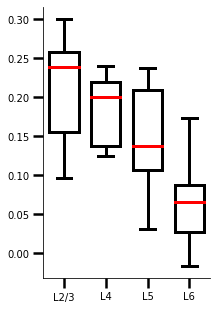

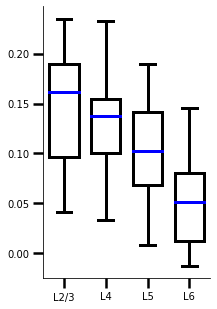

In [14]:
#Choose one of the following 5 modalities, comment out all of the rest 

corr_series = "erp_eo_rho"
#corr_series = "erp_lo_rho"
#corr_series = "psd_a_rho"
#corr_series = "psd_b_rho"
#corr_series = "psd_g_rho"

######################################################################################################

plt.figure(figsize=(15, 10))

t10 = [[], [], [], []]

for i, rhos in enumerate(ds[corr_series]):
    # Exclude the following values:
    if ds["shank"][i] == removeShank or ds["layer"][i] == "SG1" or ds["paradigm"][i] == "R": continue 

    rho_t10 = rhos[9][0]

    if ds["layer"][i] in  ["SG2", "SG3"]: l = 0
    elif ds["layer"][i] in ["G1", "G2"]: l = 1
    elif ds["layer"][i] in ["IG1", "IG2", "IG3"]: l = 2
    else: l = 3

    t10[l].append(rho_t10)

fig = plt.figure(figsize=(3,5))
ax = plt.axes()

bp10 = plt.boxplot(t10, positions = [1, 2, 3, 4], notch = False, vert = True, \
                                     showfliers = False, widths = 0.7 ,patch_artist = True)
for item in ['whiskers', 'fliers', 'caps']:
    plt.setp(bp10[item], color='k', linewidth = 3)
for item in ['boxes']: 
    plt.setp(bp10[item], color='k', linewidth = 3)     
for item in ['medians']:    
    plt.setp(bp10[item], color='red', linewidth = 3)
for patch in bp10['boxes']:
    patch.set(facecolor = 'white') 

#plt.ylim([0, 0.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.tick_params(axis='both', which='minor', width=2.5, length=5)
plt.xticks([1, 2, 3, 4], ['L2/3', 'L4', 'L5', 'L6']);
print(corr_series, "patterned paradigm")
print("L2/3 median, tau = 10:", bp10["medians"][0].get_ydata()[0])
print("L4 median, tau = 10:", bp10["medians"][1].get_ydata()[0])
print("L5 median, tau = 10:", bp10["medians"][2].get_ydata()[0])
print("L6 median, tau = 10:", bp10["medians"][3].get_ydata()[0])

#Save plot
plt.savefig(cwd + '/Analysis/Modeling/SpearmansRho_Patterned.png', dpi = 500)

###############

print("---")

t10_r = [[], [], [], []]

for i, rhos in enumerate(ds[corr_series]):
    # Exclude the following values:
    if ds["shank"][i] == removeShank or ds["layer"][i] == "SG1" or ds["paradigm"][i] == "P": continue 

    rho_t10 = rhos[9][0]

    if ds["layer"][i] in  ["SG2", "SG3"]: l = 0
    elif ds["layer"][i] in ["G1", "G2"]: l = 1
    elif ds["layer"][i] in ["IG1", "IG2", "IG3"]: l = 2
    else: l = 3

    t10_r[l].append(rho_t10)

plt.figure(figsize=(3, 5))
ax = plt.axes()

bp10 = plt.boxplot(t10_r, positions = [1, 2, 3, 4], notch = False, vert = True, \
                                     showfliers = False, widths = 0.7 ,patch_artist = True)
for item in ['whiskers', 'fliers', 'caps']:
    plt.setp(bp10[item], color='k', linewidth = 3)
for item in ['boxes']: 
    plt.setp(bp10[item], color='k', linewidth = 3)     
for item in ['medians']:    
    plt.setp(bp10[item], color='blue', linewidth = 3)
for patch in bp10['boxes']:
    patch.set(facecolor = 'white') 
    
#plt.ylim([0, 0.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', width=2.5, length=10)
ax.tick_params(axis='both', which='minor', width=2.5, length=5)
plt.xticks([1, 2, 3, 4], ['L2/3', 'L4', 'L5', 'L6']);
print(corr_series, "random paradigm")
print("L2/3 median, tau = 10:", bp10["medians"][0].get_ydata()[0])
print("L4 median, tau = 10:", bp10["medians"][1].get_ydata()[0])
print("L5 median, tau = 10:", bp10["medians"][2].get_ydata()[0])
print("L6 median, tau = 10:", bp10["medians"][3].get_ydata()[0])

#Save plot
plt.savefig(cwd + '/Analysis/Modeling/SpearmansRho_Randomized.png', dpi = 500)
